In [1]:
import pickle as pkl
import numpy as np

data = pkl.load(open('favorited_dict3.p', 'rb'))
max_item, max_user = pkl.load(open('useful_stats3.p', 'rb'))


In [2]:
for key in data:
    data[key] = np.unique(data[key]).tolist()

In [3]:
from tqdm import tqdm_notebook as tqdm

In [4]:
def create_validation(data):
    valid = {}
    for key in data:
        rated_items = data[key]
        if len(rated_items) > 1:
            valid[key] = np.random.choice(rated_items)
        else:
            valid[key] = None
    return valid
        

In [5]:
valid = create_validation(data)

In [6]:
def sample_triple(data, valid, nSamples=1):
    samples = np.zeros((nSamples, 3), dtype=int)
    keys = list(data.keys())
    users = np.random.choice(keys, nSamples) 
    samples[:, 0] = users
    
    for i, user in enumerate(tqdm(users)):
        rated_items = data[user]
        valid_item = valid[user]
        unrated_item = np.random.choice(max_item)
        while unrated_item in rated_items or unrated_item == valid_item:
            unrated_item = np.random.choice(max_item)
            
        rated_item = np.random.choice(rated_items)

        while rated_item == valid_item:
            rated_item = np.random.choice(rated_items)

        samples[i, 1] = rated_item
        samples[i, 2] = unrated_item
            
    return samples


In [7]:
import math

def sigmoid(x):
    try:
        if type(x) in (int, float, np.float64):
            return 1 / (1 + math.exp(-x))
        else:
            if len(x) == 1:
                x = np.squeeze(x)
                return 1 / (1 + math.exp(-x))
            else:
                return 1 / (1 + np.exp(-x))
    except OverflowError:
        return 0

In [8]:
#hyperparameters
k=20
lr = 0.1
lam_u = .1
lam_bias = .1
lam_rated = .1
lam_unrated = .1

In [9]:
item_biases = np.random.normal(size=max_item)
latent_items = np.random.normal(size=(max_item, k))
latent_users = np.random.normal(size=(max_user, k))


Note that all of the above values are regularized pretty good. The mean value is quite small. But the max visual_user is actually pretty big, so maybe it can use more regularization.

In [10]:
def BR_opt(rated_item_bias, unrated_item_bias, latent_user, latent_rated_item, 
           latent_unrated_item):
        

    bias_difference = rated_item_bias - unrated_item_bias
    
    if latent_user.ndim == 1:
        latent_difference = np.dot(latent_rated_item - latent_unrated_item, latent_user)
    else:
        latent_difference = np.einsum('ij,ji->i', latent_rated_item - latent_unrated_item, 
                                  np.transpose(latent_user)) 
        
    
    return (bias_difference + latent_difference)

In [11]:
def create_valid_dataset(data, valid, nItems=10): #nItems is the number of items not in train/ valid 
    
    valid_list = list(valid.items())
    valid_users = [x[0] for x in valid_list if x[1] is not None]
    valid_items = [x[1] for x in valid_list if x[1] is not None]
    valid_users = np.repeat(valid_users, nItems)
    valid_items = np.repeat(valid_items, nItems)
    
    samples = np.zeros((len(valid_users), 3), dtype=int)
    samples[:, 0] = valid_users
    samples[:, 1] = valid_items
    
    for i, user in enumerate(valid_users):
        rated_items = data[user]
        valid_item = valid[user]
        unrated_item = np.random.choice(max_item)
        while unrated_item in rated_items or unrated_item == valid_item:
            unrated_item = np.random.choice(max_item)
            
        samples[i, 2] = unrated_item
        
    return samples



In [12]:
def AUC(data, valid, item_biases, latent_items, latent_users):
    
    
    samples = create_valid_dataset(data, valid, 5)
    auc = 0.0
    for user, rated_item, unrated_item in tqdm(samples):

        # Extract out the relevant variables
        rated_item_bias = item_biases[rated_item]
        unrated_item_bias = item_biases[unrated_item]
        latent_user = latent_users[user]
        latent_rated_item = latent_items[rated_item]
        latent_unrated_item = latent_items[unrated_item]

        # Determine the output, i.e. x_uij 
        br_opt = BR_opt(rated_item_bias, unrated_item_bias, latent_user, latent_rated_item, latent_unrated_item)

        auc += (br_opt > 0)
    return auc/len(samples)

In [13]:
aucs = []

In [22]:
samples = sample_triple(data, valid, 6000000)
count = 0
for user, rated_item, unrated_item in tqdm(samples):
    
    # Extract out the relevant variables
    rated_item_bias = item_biases[rated_item]
    unrated_item_bias = item_biases[unrated_item]
    latent_user = latent_users[user]
    latent_rated_item = latent_items[rated_item]
    latent_unrated_item = latent_items[unrated_item]
    
    br_opt = BR_opt(rated_item_bias, unrated_item_bias, latent_user, latent_rated_item, latent_unrated_item)
    
    output = sigmoid(-br_opt)

    # Perform gradient updates
    item_biases[rated_item] = (1-lr*lam_bias) * rated_item_bias + lr * output
    item_biases[unrated_item] = (1-lr*lam_bias) * unrated_item_bias - lr * output
    
    latent_items[rated_item] = (1-lr*lam_rated) * latent_rated_item + lr * output * latent_user
    latent_items[unrated_item] = (1-lr*lam_unrated) * latent_unrated_item - lr * output * latent_user
    latent_users[user] = (1-lr*lam_unrated) * latent_user \
                        + lr * output * (latent_rated_item-latent_unrated_item)

    count += 1

    if count % 250000 is 0:
        aucs.append(AUC(data, valid, item_biases, latent_items, latent_users))


245108/|/  4%|| 245108/6000000 [00:17<06:42, 14283.99it/s]

495305/|/  8%|| 495305/6000000 [00:50<09:26, 9717.26it/s]

748222/|/ 12%|| 748222/6000000 [01:25<09:56, 8797.64it/s]

998658/|/ 17%|| 998658/6000000 [01:58<09:55, 8393.70it/s]

1248853/|/ 21%|| 1248853/6000000 [02:32<09:41, 8176.98it/s]

1497165/|/ 25%|| 1497165/6000000 [03:06<09:20, 8030.39it/s]

1749523/|/ 29%|| 1749523/6000000 [03:40<08:55, 7944.16it/s]

1999009/|/ 33%|| 1999009/6000000 [04:13<08:28, 7871.30it/s]

2247491/|/ 37%|| 2247491/6000000 [04:47<08:00, 7810.31it/s]

2498652/|/ 42%|| 2498652/6000000 [05:21<07:30, 7777.23it/s]

2744938/|/ 46%|| 2744938/6000000 [05:54<07:00, 7734.74it/s]

2998327/|/ 50%|| 2998327/6000000 [06:28<06:29, 7708.11it/s]

3246510/|/ 54%|| 3246510/6000000 [07:02<05:58, 7678.92it/s]

3495623/|/ 58%|| 3495623/6000000 [07:36<05:26, 7659.31it/s]

3745310/|/ 62%|| 3745310/6000000 [08:10<04:55, 7640.88it/s]

3999577/|/ 67%|| 3999577/6000000 [08:44<04:22, 7630.60it/s]

4248085/|/ 71%|| 4248085/6000000 [09:18<03:50, 7605.77it/s]

4496514/|/ 75%|| 4496514/6000000 [09:52<03:18, 7587.01it/s]

4747665/|/ 79%|| 4747665/6000000 [10:26<02:45, 7580.15it/s]

4995084/|/ 83%|| 4995084/6000000 [10:59<02:12, 7570.53it/s]

5246992/|/ 87%|| 5246992/6000000 [11:33<01:39, 7566.62it/s]

5495048/|/ 92%|| 5495048/6000000 [12:07<01:06, 7555.49it/s]

5744822/|/ 96%|| 5744822/6000000 [12:41<00:33, 7546.95it/s]

5997111/|/100%|| 5997111/6000000 [13:15<00:00, 7541.29it/s]

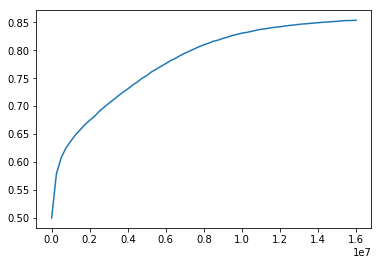

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.array(range(len(aucs)+1))*250000, [0.5]+aucs)

In [24]:
max(aucs)

0.85370452388484652

In [156]:
AUC(data, valid, item_biases, latent_items, latent_users)

KeyboardInterrupt: 